In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import caesar
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.io import fits
from scipy import interpolate
%run  guideclass.ipynb
%run  findsatellites.ipynb
cosmo = LambdaCDM(H0 = 68, Om0= 0.3, Ode0= 0.7, Ob0=0.048)
plt.rcParams.update({'font.size': 28})

In [2]:
# directory of fits files for each catalog of the m100_n1024 simba
dusty_passive_proj_path = '/home/lorenzong/Desktop/Dusty_Passive_in_SIMBA_2023/'
qg_main_dir = field_hystory = os.path.join(dusty_passive_proj_path, 'General_output/FITS/Field_FITS/Properties_FITS')
# Directory for the saving of plots
central_characterization = '/home/lorenzon/Desktop'

In [114]:
# function to plot sfh 
def easy_plot(ax, galID, propr_name, env, x, main_dir, 
              norm_propr=False,
              scale='linear', interpol=False,
              evolpts=False, thresh=False, zlim=[0, 5], color='C0'):
    
    
    # load the fits with properties for each galaxy and snapshot
    if env=='field':
        with fits.open(os.path.join(main_dir, propr_name+'.fits')) as file:
            propr_dir = file[1].data 
            propr= []
            for col in propr_dir.columns[1:]:
                propr.append(propr_dir[col.name])
            propr = np.array(propr)
            idlist = propr_dir['z0ID']
    elif env=='cluster':
        with fits.open(os.path.join(main_dir, propr_name+'.fits')) as file:
            print(os.path.join(main_dir, propr_name+'.fits'))
            propr_dir = file[1].data 
            propr = []
            for col in propr_dir.columns[1:]:
                propr.append(propr_dir[col.name])
            propr = np.array(propr)
            idlist = propr_dir['z0ID']
            
            
    # we use the redshift to cut the plot range of the property
    propr = propr[:len(x),:]
    
    # select the galaxy to plot based on the index
    toplot = idlist == galID
    # if the index is wrng give an error message
    if len(idlist[toplot])==0:
        print('ID is not valid!')
        return
    # do normalization if needed
    if isinstance(norm_propr, bool)==True:
        y = propr[:, toplot]
    elif isinstance(norm_propr, str)==True:
        # load the fits with properties for each galaxy and snapshot
        if env=='field':
            with fits.open(os.path.join(main_dir, norm_propr+'.fits')) as file:
                propr_dir = file[1].data 
                norm_propr= []
                for col in propr_dir.columns[1:]:
                    norm_propr.append(propr_dir[col.name])
                norm_propr = np.array(norm_propr)
        elif env=='cluster':
            with fits.open(os.path.join(main_dir, norm_propr+'.fits')) as file:
                propr_dir = file[1].data 
                norm_propr = []
                for col in propr_dir.columns[1:]:
                    norm_propr.append(propr_dir[col.name])
                norm_propr = np.array(norm_propr)
        
        norm_propr = norm_propr[:len(x),:]
        y = propr[:, toplot]/norm_propr[:, toplot]
    else:
        y = propr[:, toplot]/norm_propr
    y = y[:,0]    
    
    if interpol==True:
        xrange = np.linspace(x.min(), x.max(), 1000)
        propr_interp = interpolate.BSpline(x, y, k=3)
        ax.plot(xrange, propr_interp(xrange), lw=4, color=color, alpha=0.8)    
    else: 
        galplot = ax.plot(x, y, lw=4, color=color)
        
        
    if thresh:
        sf = lambda x: 1/cosmo.age(x).to(u.yr).value
        qc = lambda x: 0.2/cosmo.age(x).to(u.yr).value
        xrange = np.linspace(zlim[0], zlim[1], 1000)
        trange = (cosmo.age(0) - cosmo.age(xrange))
        ax.plot(trange, sf(xrange), ls='--', lw=3, label=r'$1/\tau(z_{q})$')
        ax.plot(trange, qc(xrange), ls=':', lw=3, label=r'$0.2/\tau(z_{q})$')
  
    if isinstance(evolpts, bool)==False:
        for i in range(len(evolpts)):
            ax.plot((cosmo.age(0) - cosmo.age(evolpts[i][0])).value, evolpts[i][1], marker='*', color='crimson',  markersize=20)
            
            
    if scale=='log':
        ax.set_yscale('log')


def Z_to_OH12(Z):
    logOH12 = np.log10(Z/0.0127)+8.69
    return logOH12

    
# calculate DTM ratio as in De Vis (2019): a systematic metallicity study of DustPedia
def Dust_to_Metal(M_dust, M_h2, abundance):
    #metal fraction
    f_z = 27.36*(10**(abundance-12))
    #metal mass
    M_z = f_z*M_h2 + M_dust
    
    DTM = M_dust/M_z
    
    return DTM

In [3]:
# now we use caesar to work with snapshot 129 which correspond to z~0.4
sb = simba('PC39BP4', size=100)
snap = 129
cs = sb.get_caesar(snap, fname=f'm100n1024_%s.hdf5')
a = cs.simulation.scale_factor
z = sb.get_redshifts()
clust_mass_thresh = 1e14

# We want all central galaxies in clusters
central_gal_ind = np.asarray([i.GroupID for i in cs.galaxies if i.central==1]) # select central galaxies
print('Total number of central galaxies: ', len(central_gal_ind))
gals_in_clusters = [i.galaxy_index_list for i in cs.halos if i.masses['total']>clust_mass_thresh] # galaxies in masive halos
gals_in_clusters = np.concatenate(gals_in_clusters)
print(f'Total number of Mtot above {clust_mass_thresh} Msun: ', len(gals_in_clusters))
central_in_cluster_id = central_gal_ind[np.isin(central_gal_ind, gals_in_clusters)]
print('Total number of central galaxies in clusters: ', len(central_in_cluster_id))

yt : [INFO     ] 2024-07-20 13:18:59,802 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_129.hdf5
yt : [INFO     ] 2024-07-20 13:18:59,971 Found 495012 halos
yt : [INFO     ] 2024-07-20 13:19:00,013 Found 46575 galaxies


Total number of central galaxies:  30429
Total number of Mtot above 100000000000000.0 Msun:  2363
Total number of central galaxies in clusters:  24


In [4]:
print(cs.galaxies[0].pos)

[121467.46875  108948.34375   17408.859375] kpccm


In [125]:
# Now that we have filtered the needed galaxies we can study their properties
Ms      = np.asarray([i.masses['stellar'] for i in cs.galaxies])[central_in_cluster_id]
Mh2     = np.asarray([i.masses['H2'] for i in cs.galaxies])[central_in_cluster_id]
Mh1     = np.asarray([i.masses['HI'] for i in cs.galaxies])[central_in_cluster_id]
Md      = np.asarray([i.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]
sfr     = np.asarray([i.sfr for i in cs.galaxies])[central_in_cluster_id]
print(sfr)
print(sfr/Ms)
ages    = np.asarray([i.ages['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
bh_fedd = np.asarray([i.bh_fedd for i in cs.galaxies])[central_in_cluster_id]
bh_mass = np.asarray([i.masses['bh'] for i in cs.galaxies])[central_in_cluster_id]
met     = np.asarray([i.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
met_cgm = np.asarray([i.metallicities['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]
T       = np.asarray([i.temperatures['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
T_cgm   = np.asarray([i.temperatures['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]

[2.89326599e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.86524014e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.21255033e-02 6.56987727e-02 0.00000000e+00 0.00000000e+00
 3.10855836e-01 0.00000000e+00 1.35419801e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[7.77055421e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.21109029e-14 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.63938149e-14 1.01598586e-13 0.00000000e+00 0.00000000e+00
 7.49441883e-13 0.00000000e+00 4.14757831e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [6]:
# we want also the info on the corresponding halos
Mhalo      = np.asarray([i.halo.masses['total'] for i in cs.galaxies])[central_in_cluster_id]
Mhalo_h2   = np.asarray([i.halo.masses['H2'] for i in cs.galaxies])[central_in_cluster_id] - Mh2
Mhalo_h1   = np.asarray([i.halo.masses['HI'] for i in cs.galaxies])[central_in_cluster_id] - Mh1
Mhalo_dust = np.asarray([i.halo.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]-Md
methalo    = np.asarray([i.halo.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
Tvir       = np.asarray([i.halo.virial_quantities['temperature'] for i in cs.galaxies])[central_in_cluster_id]

In [7]:
# calculate oxygen abundance and DTM
logoh12 = Z_to_OH12(met)
logoh12_h = Z_to_OH12(methalo)
dtm     = Dust_to_Metal(Md, Mh2, logoh12)

In [8]:
# Let's see how many satellites there are for each galaxy:
r = 50
pos = np.asarray([i.pos for i in cs.galaxies])
totids = np.asarray([i.GroupID for i in cs.galaxies])
sat_ids = {}
for targid in central_in_cluster_id:
    candids = totids[np.where(totids!=targid)[0]]
    sat_ids[targid] = findsatellites(pos[targid], pos[candids], totids, a, r=r)

Metallicity if nodust:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


/tmp/ipykernel_1600200/1947987856.py:5: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(np.log10(Mhalo), np.log10(Md / Mh2), c=logoh12, s=100)


Text(0, 0.5, '$\\log(M_{\\rm dust}/M_{\\rm H_2})$')

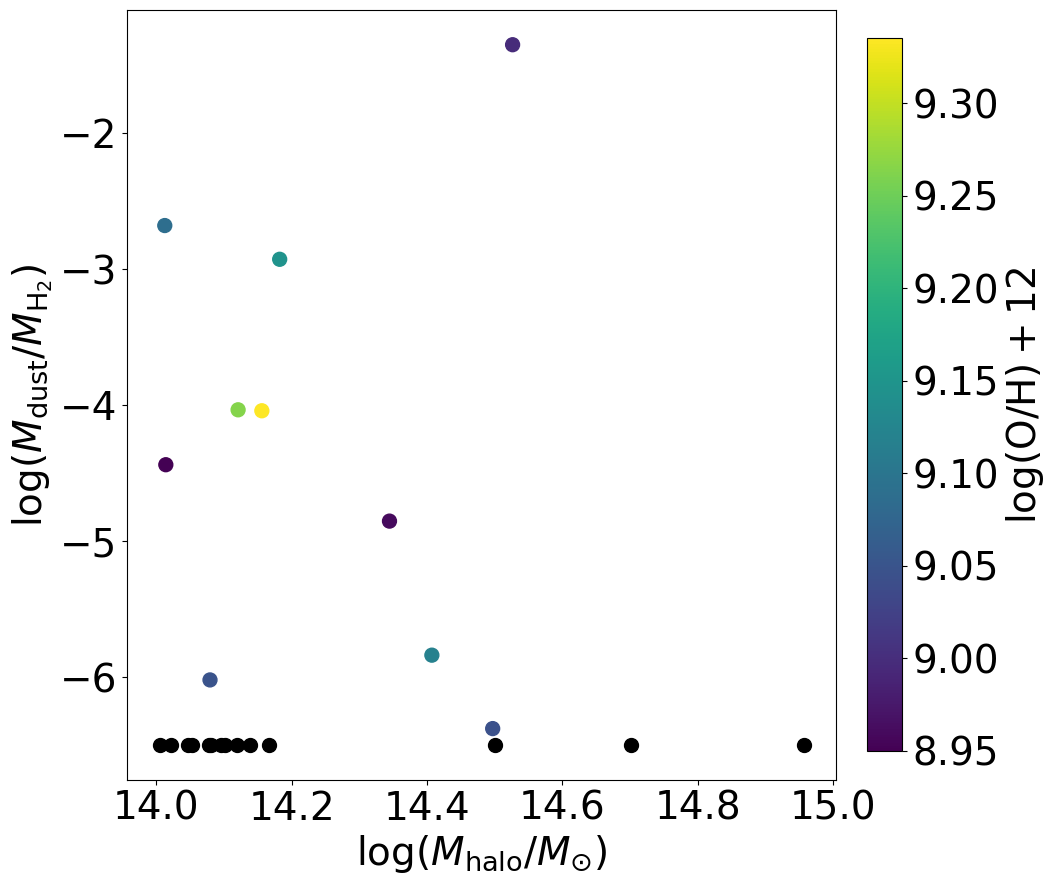

In [50]:
# DGR vs Mhalo colored with metallicity (black points are those with no dust at all)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nodust = Md == 0
print('Metallicity if nodust: ', met[nodust])
sc = ax.scatter(np.log10(Mhalo), np.log10(Md / Mh2), c=logoh12, s=100)
ax.scatter(np.log10(Mhalo)[nodust], -6.5*np.ones(len(Ms[nodust])), c='k', s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm O/H)+12$')
ax.set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')

/tmp/ipykernel_1600200/2946412823.py:8: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=Mhalo_dust/dustsat, norm=colors.LogNorm())
/tmp/ipykernel_1600200/2946412823.py:8: RuntimeWarning: divide by zero encountered in divide
  sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=Mhalo_dust/dustsat, norm=colors.LogNorm())


Text(0, 0.5, '$\\log(M_{\\rm dust}/M_{\\rm H_2})$')

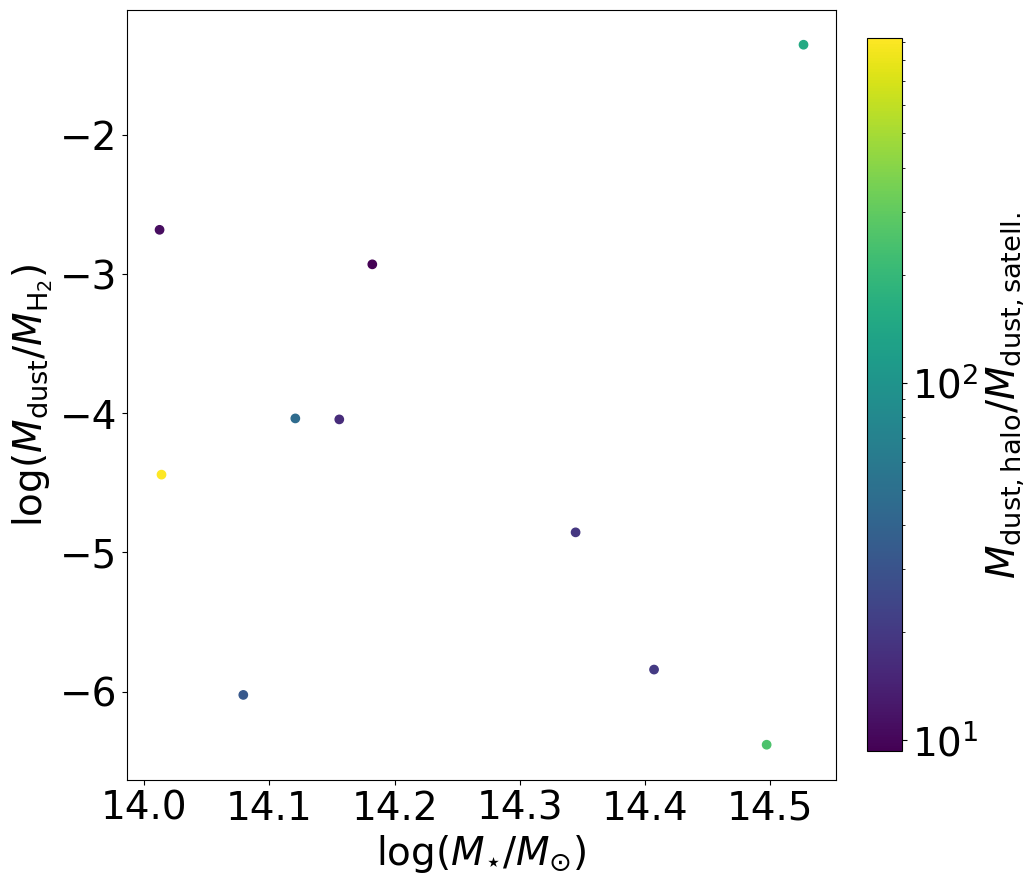

In [10]:
# DGR vs Mhalo colore with fraction of dust in the halo wrt in the satellites around the central (distance r)
nsat = np.asarray([len(sat_ids[i]) for i in sat_ids])
Md_tot      = np.asarray([i.masses['dust'] for i in cs.galaxies])
Ms_tot      = np.asarray([i.masses['stellar'] for i in cs.galaxies])
dustsat = np.asarray([sum(Md_tot[sat_ids[i]]) for i in sat_ids])
masssat = np.asarray([sum(Ms_tot[sat_ids[i]]) for i in sat_ids])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=Mhalo_dust/dustsat, norm=colors.LogNorm(), s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, halo}/M_{\rm dust, satell.}$')
ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')

/tmp/ipykernel_1600200/3566100849.py:8: RuntimeWarning: divide by zero encountered in log10
  sc = plt.scatter(np.log10(Mhalo_dust/Mhalo), np.log10(dustsat/Ms), c=Md/Ms, s=nsat*20, norm=colors.LogNorm())


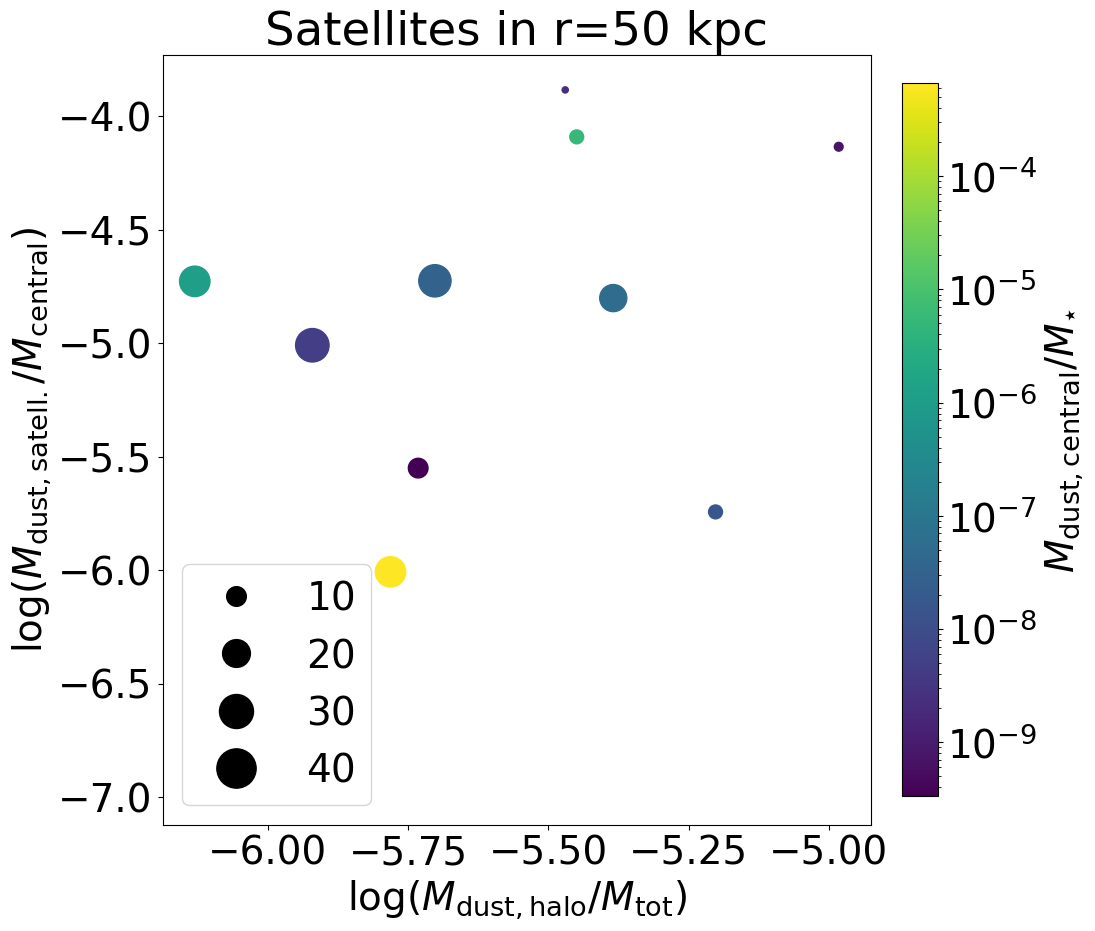

In [97]:
# Comparison with dust/star in the satellites around the central (at distance r) vs the fraction of dust diffused in the halo (so not in galaxies)
# colored with the dust fraction i n the central
# The size represents the number of satellites
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
minreplace = dustsat[dustsat!=0].min()-0.3*dustsat[dustsat!=0].min()
#dustsat[dustsat==0] = minreplace #pay attention here: run cell only once
#ax.axhline(np.log10(minreplace), ls='--', c='r')
sc = plt.scatter(np.log10(Mhalo_dust/Mhalo), np.log10(dustsat/Ms), c=Md/Ms, s=nsat*20, norm=colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, central}/M_{\star}$')
ax.set_xlabel(r'$\log(M_{\rm dust, halo}/M_{\rm tot})$')
ax.set_ylabel(r'$\log(M_{\rm dust, satell.}/M_{\rm central})$')
ax.set_title(f'Satellites in r={r} kpc')
plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/20))
fig.savefig('satellite-halo-central_dust.png', bbox_inches='tight')

/tmp/ipykernel_1600200/2234291652.py:11: RuntimeWarning: divide by zero encountered in log10
  sc1 = ax[1,0].scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=logoh12, s=100)
/tmp/ipykernel_1600200/2234291652.py:16: RuntimeWarning: divide by zero encountered in log10
  sc1 = ax[1,1].scatter(np.log10(Mhalo), np.log10(Md/Mh1), c=logoh12, s=100)


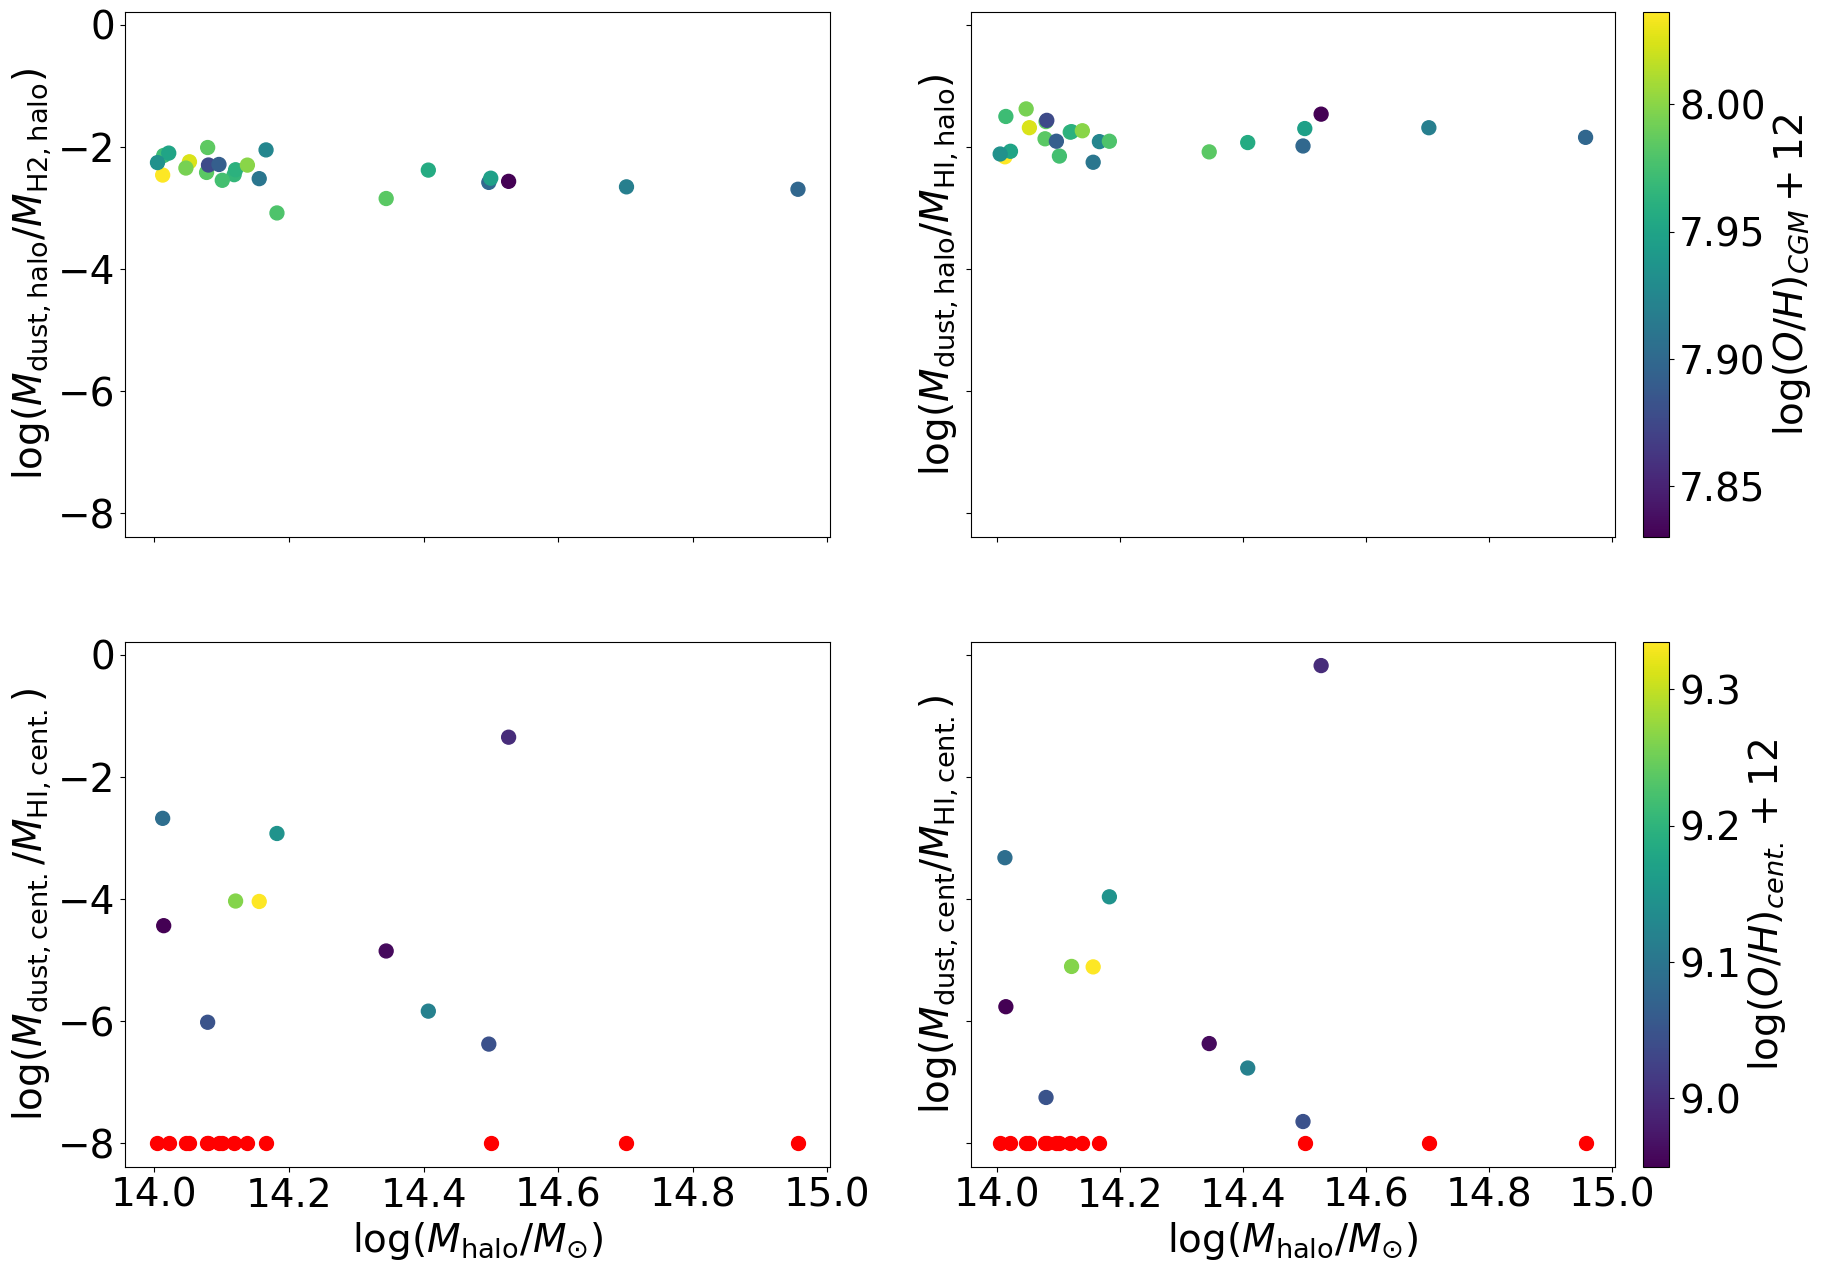

In [88]:
# metallicity of the galaxy compared with the satellites and the halo
fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharex=True, sharey=True)
sc = ax[0,0].scatter(np.log10(Mhalo), np.log10(Mhalo_dust/Mhalo_h2), c=logoh12_h, s=100)
ax[0,0].set_ylabel(r'$\log(M_{\rm dust, halo}/M_{\rm H2, halo})$')

sc1 = ax[0,1].scatter(np.log10(Mhalo), np.log10(Mhalo_dust/Mhalo_h1), c=logoh12_h, s=100)
cbar = fig.colorbar(sc1, ax=ax[0,1], fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(O/H)_{CGM}+12$')
ax[0,1].set_ylabel(r'$\log(M_{\rm dust, halo}/M_{\rm HI, halo})$')

sc1 = ax[1,0].scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=logoh12, s=100)
ax[1,0].scatter(np.log10(Mhalo)[nodust], -8*np.ones(len(Md[nodust])), c='r', s=100)
ax[1,0].set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax[1,0].set_ylabel(r'$\log(M_{\rm dust, cent.}/M_{\rm HI, cent.})$')

sc1 = ax[1,1].scatter(np.log10(Mhalo), np.log10(Md/Mh1), c=logoh12, s=100)
ax[1,1].scatter(np.log10(Mhalo)[nodust], -8*np.ones(len(Md[nodust])), c='r', s=100)
cbar = fig.colorbar(sc1, ax=ax[1,1], fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(O/H)_{cent.}+12$')
ax[1,1].set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax[1,1].set_ylabel(r'$\log(M_{\rm dust, cent}/M_{\rm HI, cent.})$')

fig.savefig('Halo-central_met_comparison.png')

/tmp/ipykernel_1600200/3272904015.py:12: RuntimeWarning: divide by zero encountered in log10
  sc1 = ax[1,0].scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=np.log10(T_cgm), s=100)
/tmp/ipykernel_1600200/3272904015.py:17: RuntimeWarning: divide by zero encountered in log10
  sc1 = ax[1,1].scatter(np.log10(Mhalo), np.log10(Md/Mh1), c=np.log10(T_cgm), s=100)


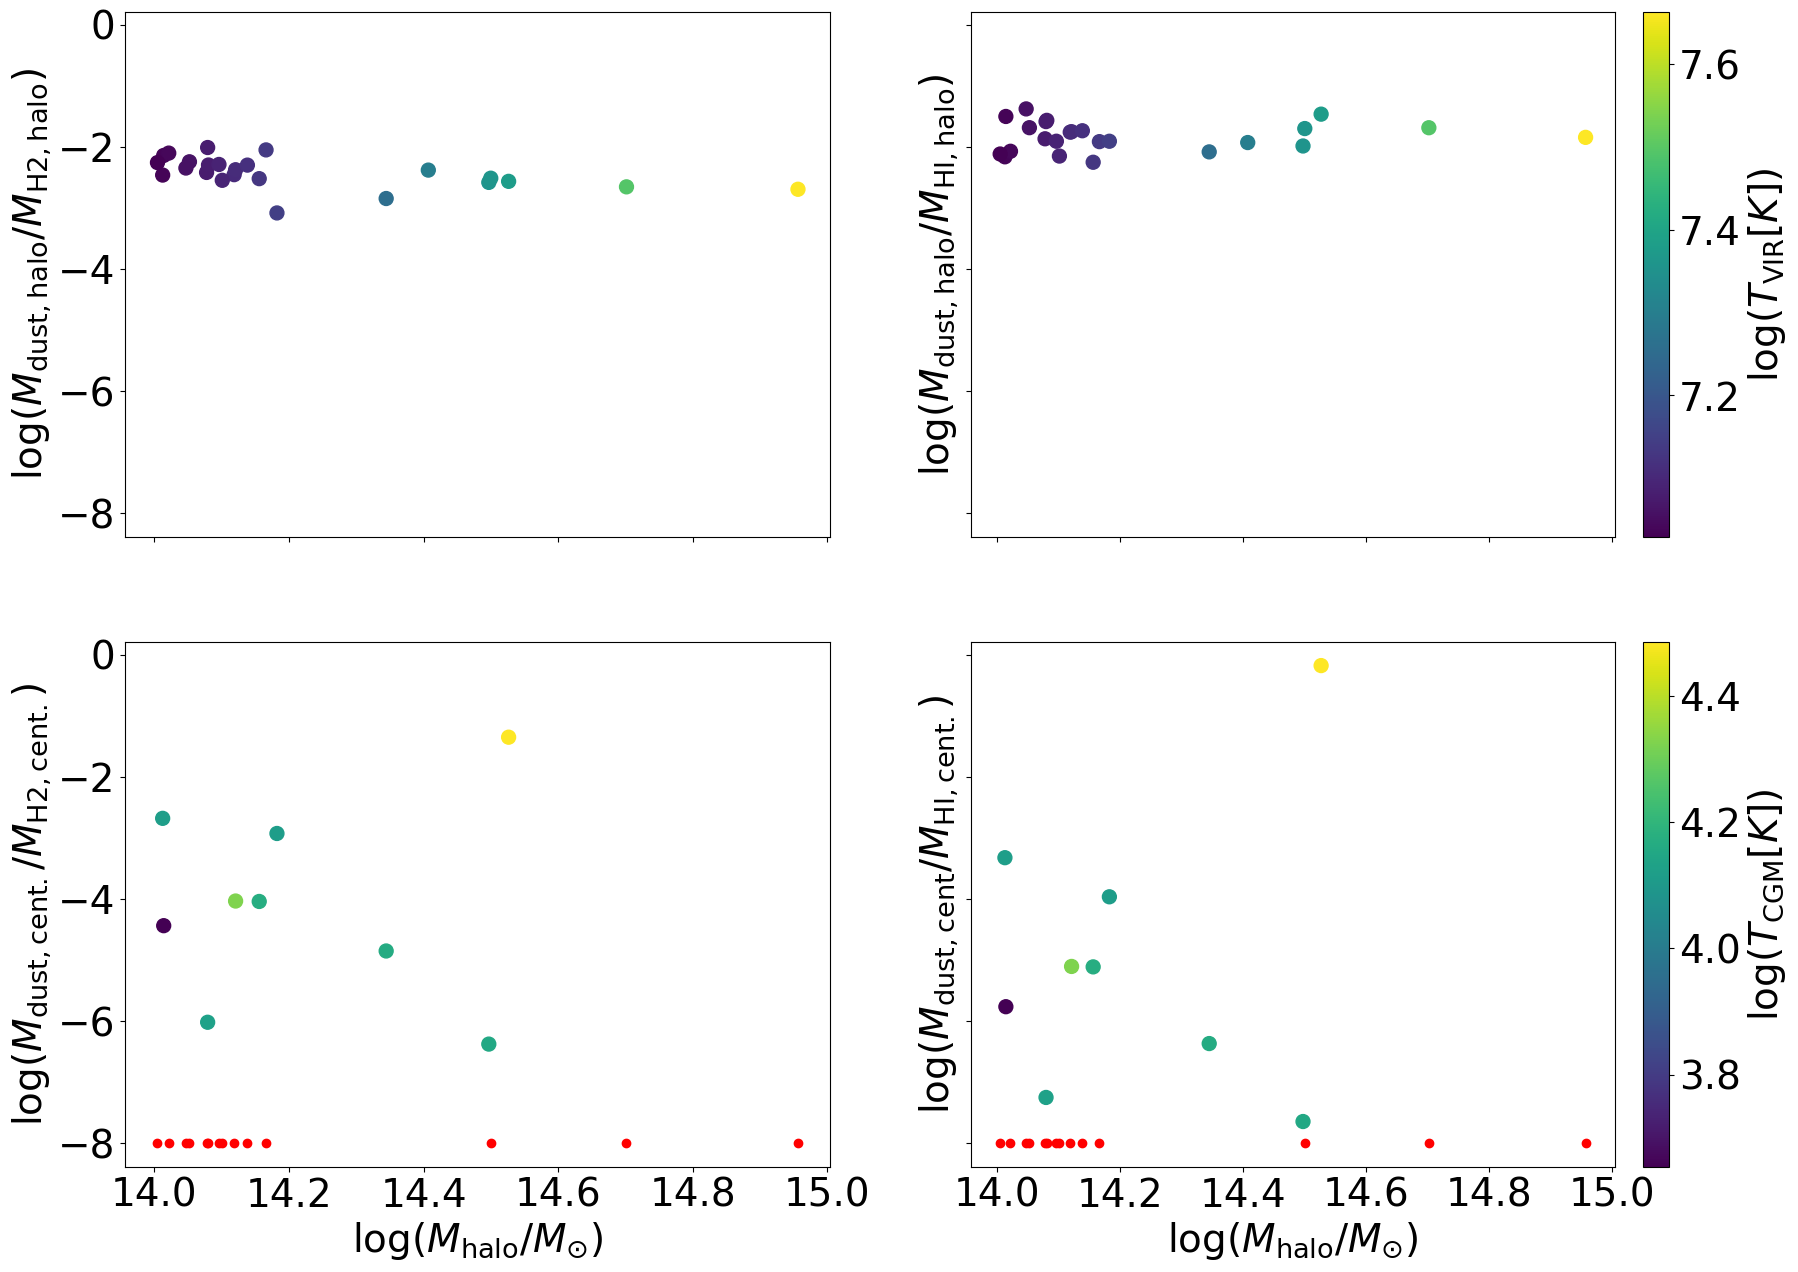

In [85]:
# properties of the central galaxies
# metallicity of the galaxy compared with the satellites and the halo
fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharex=True, sharey=True)
sc = ax[0,0].scatter(np.log10(Mhalo), np.log10(Mhalo_dust/Mhalo_h2), c=np.log10(Tvir), s=100)
ax[0,0].set_ylabel(r'$\log(M_{\rm dust, halo}/M_{\rm H2, halo})$')

sc1 = ax[0,1].scatter(np.log10(Mhalo), np.log10(Mhalo_dust/Mhalo_h1), c=np.log10(Tvir), s=100)
cbar = fig.colorbar(sc1, ax=ax[0,1], fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(T_{\rm VIR} [K])$')
ax[0,1].set_ylabel(r'$\log(M_{\rm dust, halo}/M_{\rm HI, halo})$')

sc1 = ax[1,0].scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=np.log10(T_cgm), s=100)
ax[1,0].scatter(np.log10(Mhalo)[nodust], -8*np.ones(len(Md[nodust])), c='r')
ax[1,0].set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax[1,0].set_ylabel(r'$\log(M_{\rm dust, cent.}/M_{\rm H2, cent.})$')

sc1 = ax[1,1].scatter(np.log10(Mhalo), np.log10(Md/Mh1), c=np.log10(T_cgm), s=100)
ax[1,1].scatter(np.log10(Mhalo)[nodust], -8*np.ones(len(Md[nodust])), c='r')
cbar = fig.colorbar(sc1, ax=ax[1,1], fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(T_{\rm CGM} [K])$')
ax[1,1].set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax[1,1].set_ylabel(r'$\log(M_{\rm dust, cent}/M_{\rm HI, cent.})$')

fig.savefig('Halo-central_T_comparison.png')

/tmp/ipykernel_1600200/4283838699.py:5: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=np.log10(sfr/Ms), s=nsat*20)
/tmp/ipykernel_1600200/4283838699.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(Mhalo)[nosat], np.log10(Md/Mh2)[nosat], marker='*', c=np.log10(sfr/Ms)[nosat], s=200)


Text(0, 0.5, '$\\log(M_{\\rm dust}/M_{H2})$')

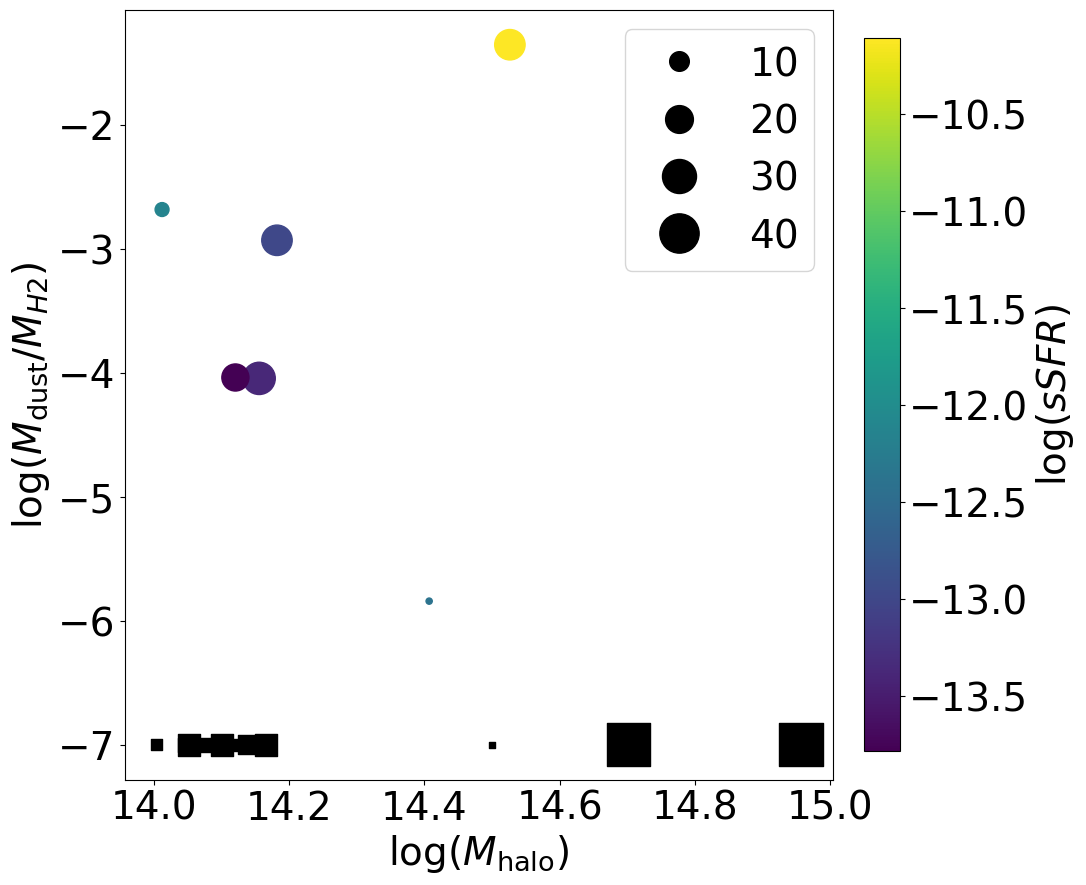

In [49]:
# properties of the central galaxies
# metallicity of the galaxy compared with the satellites and the halo
nosat = nsat == 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=np.log10(sfr/Ms), s=nsat*20)
ax.scatter(np.log10(Mhalo)[nosat], np.log10(Md/Mh2)[nosat], marker='*', c=np.log10(sfr/Ms)[nosat], s=200)
ax.scatter(np.log10(Mhalo)[nodust], -7*np.ones(len(Md[nodust])), marker='s', c='k', s=nsat[nodust]*20)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label=r'$\log(sSFR)$')
plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/20))

ax.set_xlabel(r'$\log(M_{\rm halo})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{H2})$')

/tmp/ipykernel_1600200/463337383.py:5: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=ages, s=nsat*20)
/tmp/ipykernel_1600200/463337383.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(Mhalo)[nosat], np.log10(Md/Mh2)[nosat], marker='*', c=ages[nosat], s=200)


Text(0, 0.5, '$\\log(M_{\\rm dust}/M_{H2})$')

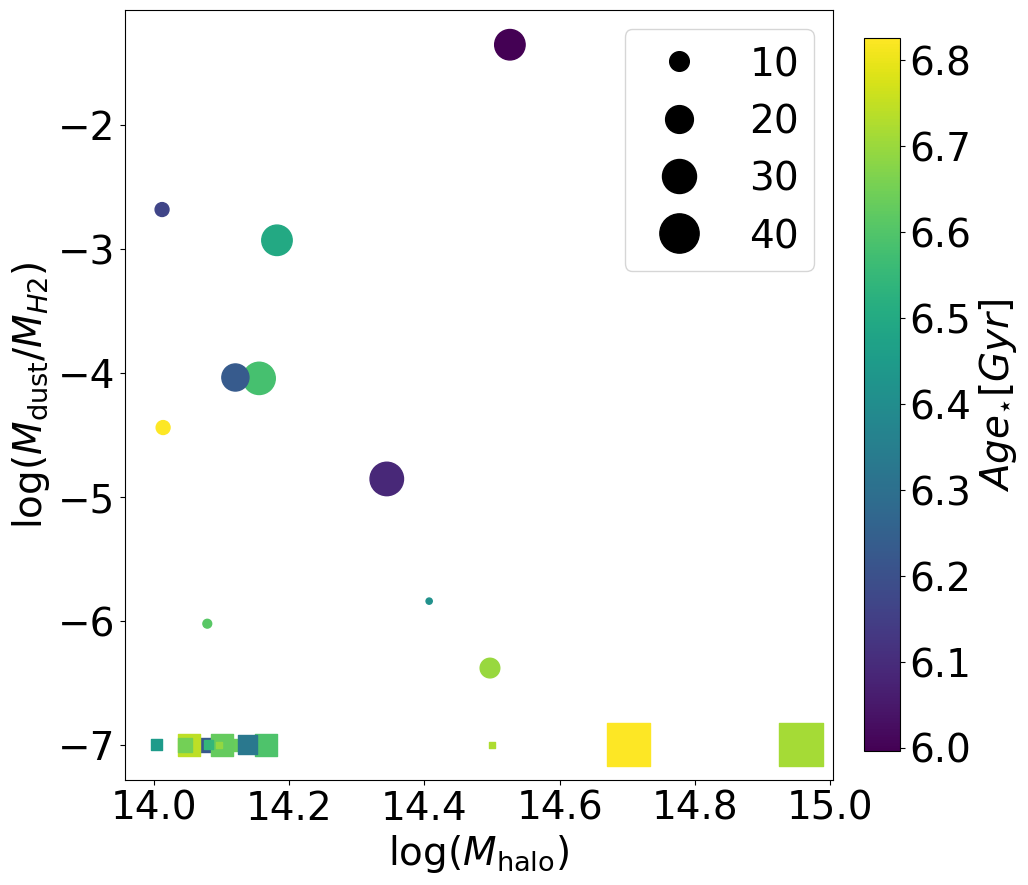

In [78]:
# properties of the central galaxies
# metallicity of the galaxy compared with the satellites and the halo
nosat = nsat == 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=ages, s=nsat*20)
ax.scatter(np.log10(Mhalo)[nosat], np.log10(Md/Mh2)[nosat], marker='*', c=ages[nosat], s=200)
ax.scatter(np.log10(Mhalo)[nodust], -7*np.ones(len(Md[nodust])), marker='s', c=ages[nodust], s=nsat[nodust]*20)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label=r'$Age_{\star} [Gyr]$')
plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/20))

ax.set_xlabel(r'$\log(M_{\rm halo})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{H2})$')

In [79]:
exgal = np.where(Md/Mh2==(Md/Mh2).max())[0]
print('Ms', np.log10(Ms)[exgal])
print('Md', np.log10(Md)[exgal])
print('Mh2', np.log10(Mh2)[exgal])
print('Mh1', np.log10(Mh1)[exgal])
print('Met', logoh12[exgal])
print('sSFR', np.log10(sfr[exgal]/Ms[exgal]))
print('age', ages[exgal])
print('Mhalo', np.log10(Mhalo)[exgal])
print('T_cgm', np.log10(T_cgm)[exgal])
print('T_halo', np.log10(Tvir)[exgal])
print('met_halo', logoh12_h[exgal])
print(f'Number of satellites in r={r} Kpc', nsat[exgal])
print('Satellite massfrac: ', Ms[exgal]/Ms_tot[sat_ids[exgal[0]]])

Ms [12.57093637]
Md [9.39012061]
Mh2 [10.74135156]
Mh1 [9.56777006]
Met [8.99654144]
sSFR [-10.10954801]
age [5.99586105]
Mhalo [14.52636108]
T_cgm [4.48515826]
T_halo [7.37695149]
met_halo [7.83025301]
Number of satellites in r=50 Kpc [24]
Satellite massfrac:  [ 5612.45804694  5941.51362267  6021.590962    6205.8686904
  6913.69179011  7285.15564158  7286.02011575  7480.56709024
  8033.52610054  8858.54972996  8924.02797728  9755.98734891
  9878.74777378 10027.97004451 10173.96804078 10263.46279549
 10449.54116368 10568.85514278 10615.32559084 10651.84735539
 10751.02734987 11282.19008883 11920.4940912  12028.34679616]


/tmp/ipykernel_1600200/2370923713.py:3: RuntimeWarning: divide by zero encountered in log10
  print('Md', np.log10(Md)[exgal])
/tmp/ipykernel_1600200/2370923713.py:10: RuntimeWarning: divide by zero encountered in log10
  print('T_cgm', np.log10(T_cgm)[exgal])


In [101]:
(Md[exgal]/Mh2[exgal])

array([0.04454193])

ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!
ID is not valid!


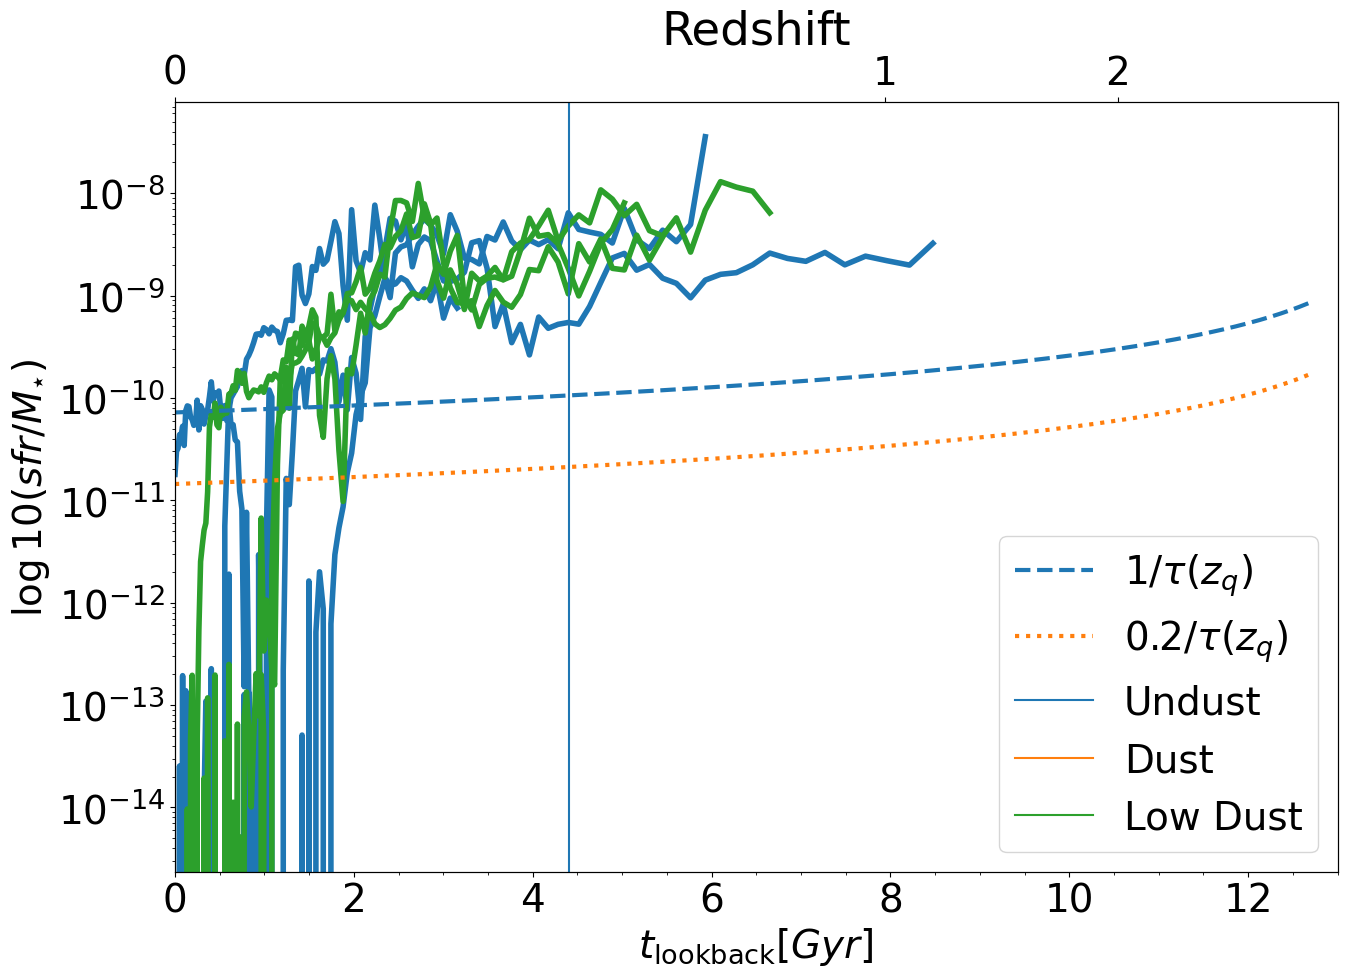

In [13]:
# We want to see the history of these galaxies
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for gid in central_in_cluster_id[nodust]:
    easy_plot(ax, gid, 'sfr', 'cluster', sb.get_redshifts()[:128], qg_main_dir, 
              norm_propr='stellar_mass',
              scale='linear', interpol=False,
              evolpts=False, thresh=False, zlim=[0, 5], color='C0')


verydust = Md/Mh2 > 1e-4
lowdust  = np.all([Md/Mh2>0, Md/Mh2<1e-4], axis=0) 

for gid in central_in_cluster_id[verydust]:
    easy_plot(ax, gid, 'sfr', 'cluster', sb.get_redshifts()[:128], qg_main_dir, 
              norm_propr='stellar_mass',
              scale='linear', interpol=False,
              evolpts=False, thresh=False, zlim=[0, 5], color='C1')


for gid in central_in_cluster_id[lowdust]:
    easy_plot(ax, gid, 'sfr', 'cluster', sb.get_redshifts()[:128], qg_main_dir, 
              norm_propr='stellar_mass',
              scale='linear', interpol=False,
              evolpts=False, thresh=False, zlim=[0, 5], color='C2')


easy_plot(ax, gid, 'sfr', 'cluster', sb.get_redshifts()[:128], qg_main_dir, 
          norm_propr='stellar_mass',
          scale='linear', interpol=False,
          evolpts=False, thresh=True, zlim=[0, 5], color='None')

ax.plot([-1,-0.1], [0, 0], c='C0', label='Undust')
ax.plot([-1,-0.1], [0, 0], c='C1', label='Dust')
ax.plot([-1,-0.1], [0, 0], c='C2', label='Low Dust')

ax.set_yscale('log')
ax.set_xlim(0, 10)
ax.set_xlabel(r'$t_{\rm lookback} [Gyr]$')
ax.set_ylabel(r'$\log10(sfr/M_{\star})$')

ax.axvline((cosmo.age(0)-cosmo.age(0.4)).value)

redshifts = np.array([0, 1, 2])
ageticks = [(cosmo.age(0) - cosmo.age(age)).value for age in redshifts]
ax2 = ax.twiny()
ax2.set_xticks(ageticks)
ax2.set_xticklabels(['{:g}'.format(age) for age in redshifts])
zmin, zmax = 0, 13
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)
ax.minorticks_on()
ax.set_title('Redshift')

ax.legend()

/home/lorenzong/Desktop/Dusty_Passive_in_SIMBA_2023/General_output/FITS/Cluster_FITS/Properties_FITS/sfr.fits


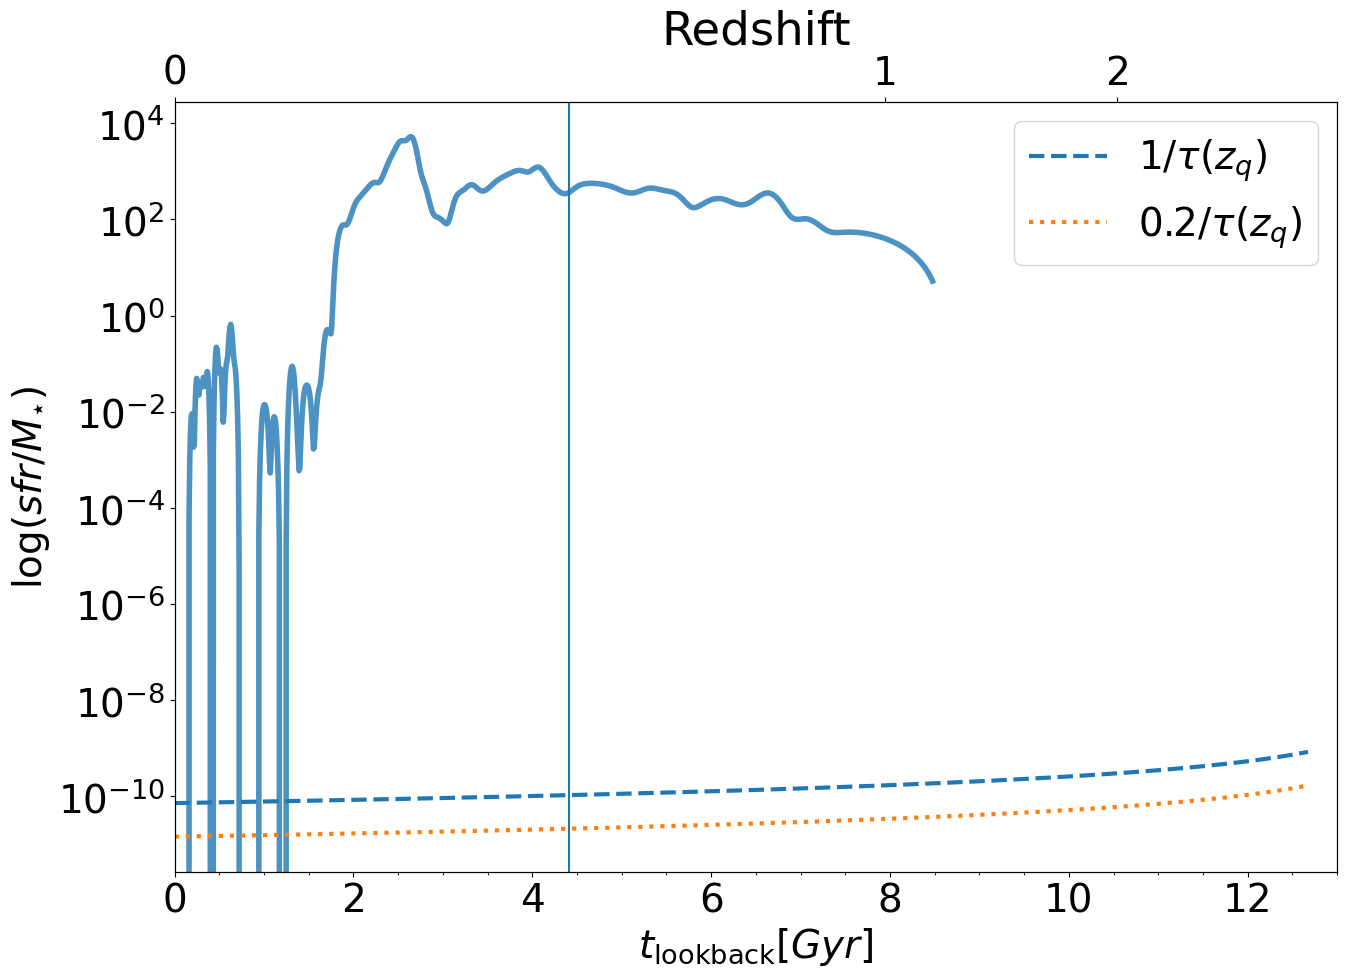

In [127]:
# We want to see the history of these galaxies
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
qg_main_dir = field_hystory = os.path.join(dusty_passive_proj_path, 'General_output/FITS/Cluster_FITS/Properties_FITS')
easy_plot(ax, 0, 'sfr', 'cluster', sb.get_redshifts()[:128], qg_main_dir, 
          norm_propr=False,
          scale='linear', interpol=True,
          evolpts=False, thresh=True, zlim=[0, 5], color='C0')

ax.set_yscale('log')
ax.set_xlim(0, 10)
ax.set_xlabel(r'$t_{\rm lookback} [Gyr]$')
ax.set_ylabel(r'$\log(sfr/M_{\star})$')

ax.axvline((cosmo.age(0)-cosmo.age(0.4)).value)

redshifts = np.array([0, 1, 2])
ageticks = [(cosmo.age(0) - cosmo.age(age)).value for age in redshifts]
ax2 = ax.twiny()
ax2.set_xticks(ageticks)
ax2.set_xticklabels(['{:g}'.format(age) for age in redshifts])
zmin, zmax = 0, 13
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)
ax.minorticks_on()
ax.set_title('Redshift')
#ax.axhline((sfr/Ms)[0])

ax.legend()